# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

## Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Create an instance of the BlackJack environment

In [2]:
blackjack_env = gym.make('Blackjack-v0')

Take a look at the action space and observation space

The agent will have two actions at each state:
- hit (1)
- stick (0)

The state has three variables:
- The current sum of player's card ({1...31})
- The face up value of dealer's card ({1...10}), "1" represents ace
- usable ace, "0" for not usable and "1" for usable

In [3]:
print(blackjack_env.action_space)
print(blackjack_env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


Try to play some random policy

In [4]:
for episode in range(100):
    state = blackjack_env.reset()
    
    while True:
        print(state)
        action = blackjack_env.action_space.sample()
        print(action)
        
        state, reward, done, info = blackjack_env.step(action)
        
        if done:  # episode ends
            print(f'Game Ends. Terminate State = {state}, Rewards = {reward}')
            break

(12, 10, False)
0
Game Ends. Terminate State = (12, 10, False), Rewards = -1.0
(11, 3, False)
1
(21, 3, False)
1
Game Ends. Terminate State = (31, 3, False), Rewards = -1
(16, 1, False)
0
Game Ends. Terminate State = (16, 1, False), Rewards = -1.0
(9, 10, False)
1
(16, 10, False)
1
Game Ends. Terminate State = (22, 10, False), Rewards = -1
(6, 10, False)
1
(16, 10, False)
1
Game Ends. Terminate State = (26, 10, False), Rewards = -1
(20, 8, False)
1
Game Ends. Terminate State = (30, 8, False), Rewards = -1
(14, 7, False)
1
(20, 7, False)
1
Game Ends. Terminate State = (30, 7, False), Rewards = -1
(17, 1, False)
0
Game Ends. Terminate State = (17, 1, False), Rewards = 0.0
(15, 4, False)
0
Game Ends. Terminate State = (15, 4, False), Rewards = 1.0
(17, 10, False)
1
(18, 10, False)
0
Game Ends. Terminate State = (18, 10, False), Rewards = -1.0
(21, 2, True)
0
Game Ends. Terminate State = (21, 2, True), Rewards = 1.0
(20, 10, False)
0
Game Ends. Terminate State = (20, 10, False), Rewards = 

## Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()

    while True:
        hit_stick_prob = [0.2, 0.8] if state[0] > 18 else [0.8, 0.2]
        action = np.random.choice([1, 0], p=hit_stick_prob)
        new_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = new_state
        
        if done:
            break
    
    return episode

In [6]:
for _ in range(3):
    print(generate_episode_from_limit_stochastic(blackjack_env))

[((14, 9, False), 0, -1.0)]
[((12, 2, False), 1, -1)]
[((17, 9, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

### First-visit MC prediction

In [7]:
def first_visit_mc_prediction(env, num_episodes, generate_episode, gamma=1):
    q = defaultdict(lambda: [0] * env.action_space.n)
    visit_count = defaultdict(lambda: [0] * env.action_space.n)
    
    for _ in range(num_episodes):
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = [gamma ** i for i in range(len(rewards))]
        visited_spaces = set()
        
        for i, state in enumerate(states):
            if (state, actions[i]) in visited_spaces:
                continue
            
            discounted_return = 0
            for j, reward in enumerate(rewards[i:]):
                discounted_return += reward * discounts[j]
            
            current_q = q[state][actions[i]]
            current_count = visit_count[state][actions[i]]
            new_q = (current_q * current_count + discounted_return) / (current_count + 1)
            q[state][actions[i]] = new_q
            visit_count[state][actions[i]] += 1
            visited_spaces.add((state, actions[i]))

    return q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

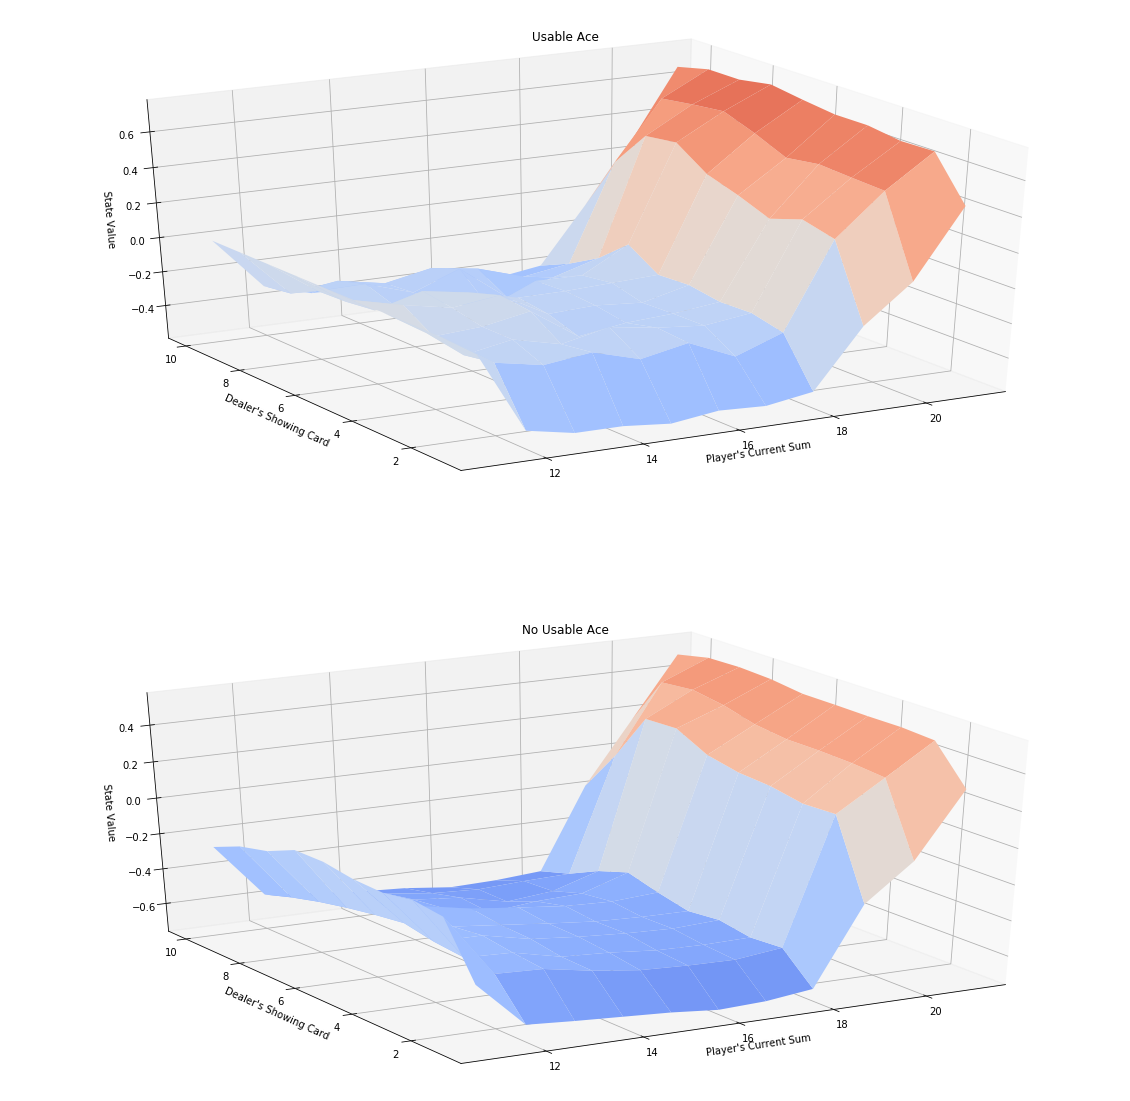

In [8]:
# obtain the action-value function
Q = first_visit_mc_prediction(blackjack_env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Every-visit MC prediction

In [9]:
def every_visit_mc_prediction(env, num_episodes, generate_episode, gamma=1):
    q = defaultdict(lambda: [0] * env.action_space.n)  # list = [action_space]
    visit_count = defaultdict(lambda: [0] * env.action_space.n)  # list = [action_space]

    for _ in range(num_episodes):
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = [gamma ** i for i in range(len(rewards))]

        for i, state in enumerate(states):
            
            # calculate discounted reward
            discounted_return = 0
            for j, reward in enumerate(rewards[i:]):
                discounted_return += reward * (discounts[j])
            
            # update q
            current_q = q[state][actions[i]]
            current_count = visit_count[state][actions[i]]
            new_q = (current_q * current_count + discounted_return) / (current_count + 1)
            q[state][actions[i]] = new_q
            visit_count[state][actions[i]] += 1
    
    return q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

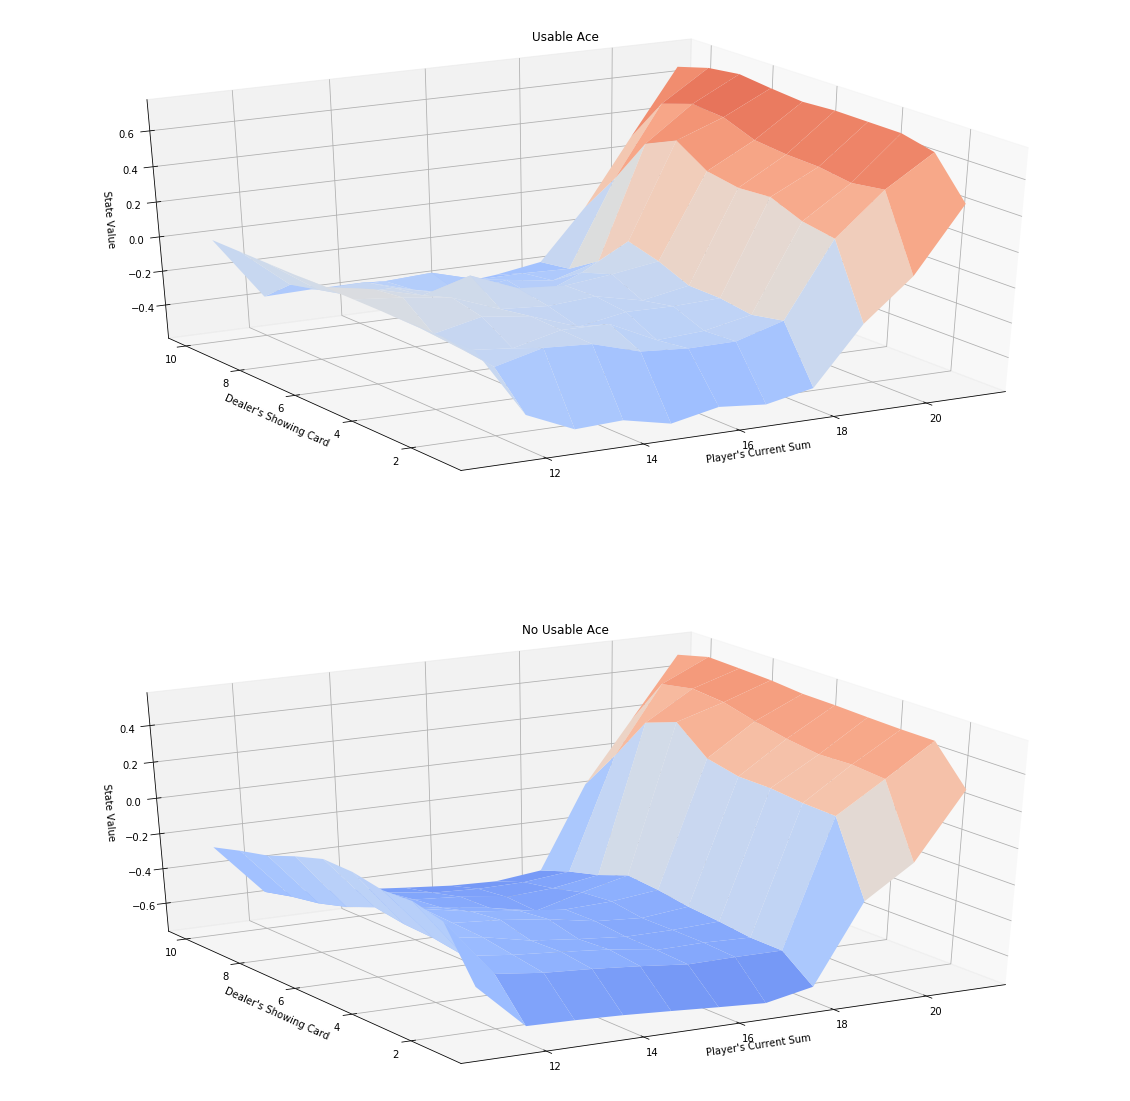

In [10]:
# obtain the action-value function
Q = every_visit_mc_prediction(blackjack_env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

## Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [60]:
def contant_alpha_mc_control(env, num_episodes, alpha, gamma=1):
    q = defaultdict(lambda: [0] * env.action_space.n)
    policy = defaultdict(int)
    
    for e in range(num_episodes):
        print(f'\rEpisode {e+1}/{num_episodes}.', end='')

        episode = run_episode_using_epsilon_greedy(env, q)
        states, actions, rewards = zip(*episode)
        discounts = [gamma ** i for i in range(len(rewards))]
        
        for i, state in enumerate(states):
            policy[state] = actions[i]  # update the policy dictionary
            
            G = 0
            for j, reward in enumerate(rewards[i:]):
                G += reward * discounts[j]
            
            q[state][actions[i]] += alpha * (G - q[state][actions[i]])
            
    return q, policy

    
def run_episode_using_epsilon_greedy(env, q, epsilon=0.1):
    episode = []
    state = env.reset()
    
    while True:
        action = epsilon_greedy(q, state, epsilon)
        new_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        
        if done:
            return episode


def epsilon_greedy(q, state, epsilon):
    """
    pick action using epsilon-greedy policy
    """
    q_actions, num_actions = q[state], len(q[state])
    p_greedy = 1 - epsilon + epsilon / num_actions
    p_random = epsilon / num_actions
    pick_greedy = np.random.choice([True, False], p=[p_greedy, p_random])
    
    if pick_greedy:
        argmax = np.argwhere(q_actions == np.max(q_actions)).flatten().tolist()
        action = np.random.choice(argmax)
    else:
        action = np.random.choice(list(range(num_actions)))

    return action

In [62]:
# obtain the estimated optimal policy and action-value function
Q, policy = contant_alpha_mc_control(blackjack_env, 500000, 0.01)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

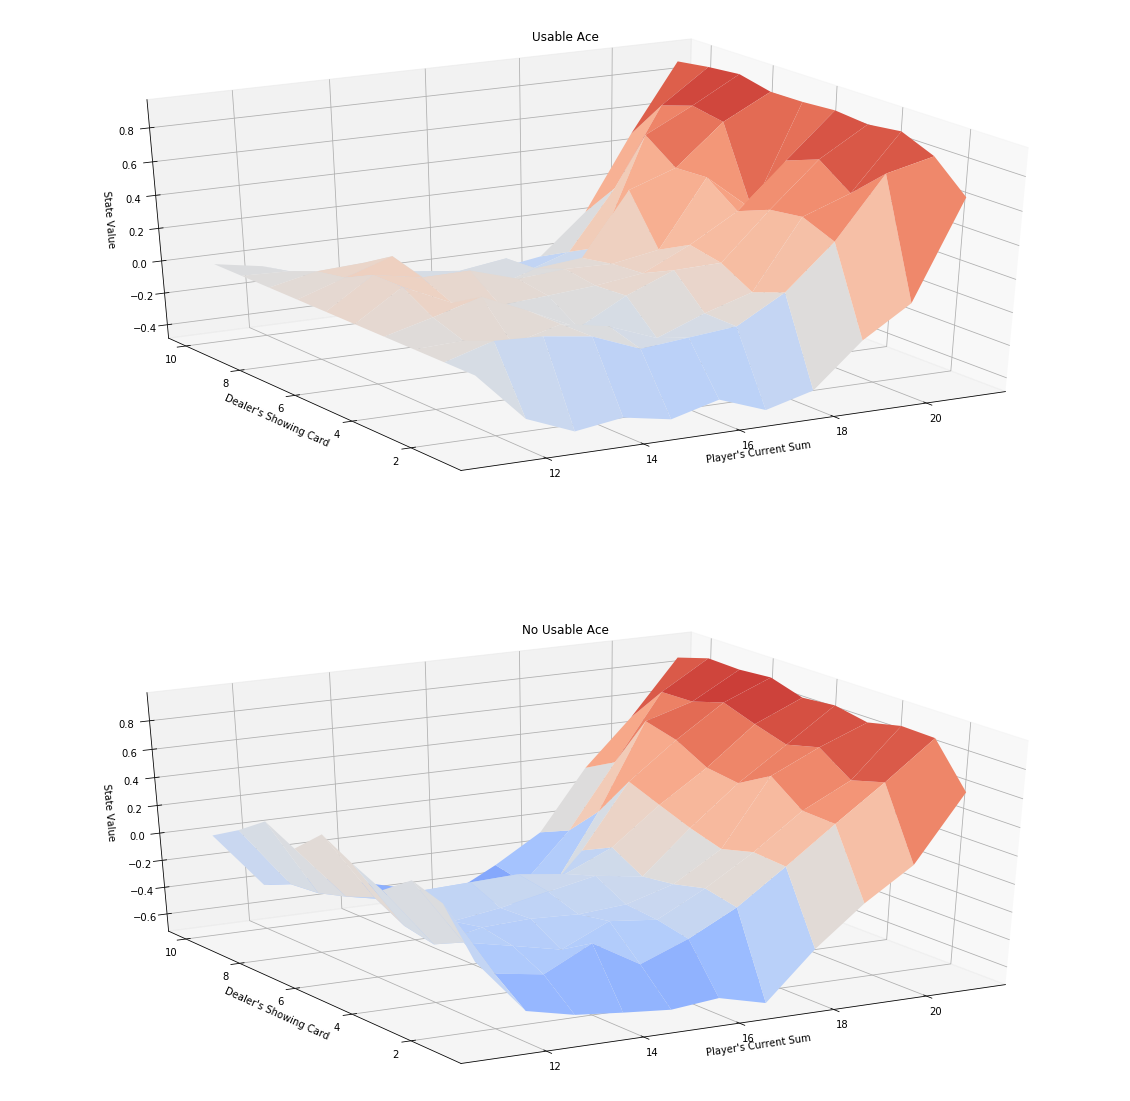

In [63]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

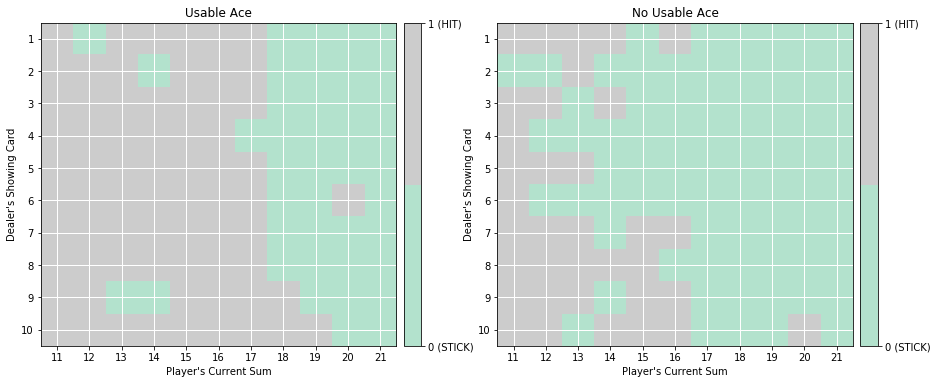

In [64]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)